In [1]:
import requests
import json

import numpy as np

import astropy
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.table import Table, vstack

from astroquery.imcce import Skybot

import matplotlib.pyplot as plt

from plot_utils import iter_over_obj, plot_all_objs, plot_focal_plane

%matplotlib inline

# Objects crossing COSMOS 1 field of DDF in 2021

## DDF and COSMOS 1 Field

The Deep Drilling Field (DDF) is an optical imaging survey conducted with the Dark Energy Camera (DECam) on the 4-m Blanco telescope at the Cerro Tololo Inter-American Observatory (CTIO) repeatedly images several fields (refered to as COSMOS 1, 2 and 3 and DECals). The part of survey considered here covers the target named "COSMOS 1" over ~40 epochs (nights) per field and 5 to 6 images per night per filter in g, r, i, and/or z. The subset covers the timespan from 2021-03-19 to 2022-01-24 (21A and 21B halves). 

The survey is described in more depth in [this paper](https://ui.adsabs.harvard.edu/abs/2023MNRAS.519.3881G/abstract). 

The COSMOS 1 field is generally located at:

In [2]:
ra_center = 150.002625
dec_center = 3.09713889

DECam and CTIO cover approximately 3 square degrees on the sky, i.e. it spans the radius of:

In [3]:
radius = 1.15 # degrees

Important note to clarify here is that within the COSMOS 1 target the provided coordinates mark the more common pointing, but there is another one neighbouring the given coordinates at:

In [4]:
ra_secondary = 149.220167
dec_secondary = 1.749694

The two pointings are two neighbouring fields. There are 126 of these alternate pointings compared to 449 primary pointings.

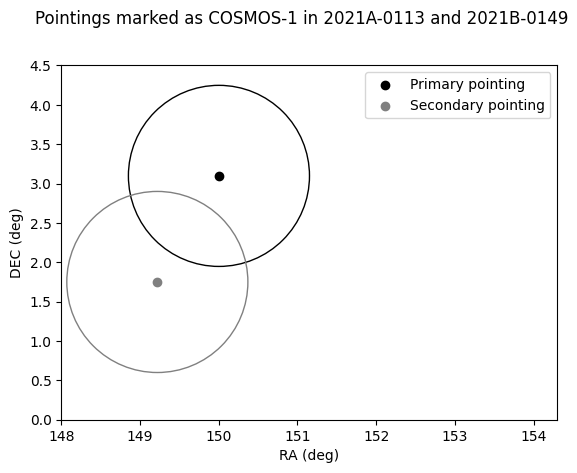

In [5]:
fig, ax = plt.subplots()
fig.suptitle("Pointings marked as COSMOS-1 in 2021A-0113 and 2021B-0149")
ax.scatter(ra_center, dec_center, color="black", label="Primary pointing")
ax.scatter(ra_secondary, dec_secondary, color="gray", label="Secondary pointing")
circ1 = plt.Circle((ra_center, dec_center), radius, fill=False, color="black")
circ2 = plt.Circle((ra_secondary, dec_secondary), radius, fill=False, color="gray")
ax.add_artist(circ1)
ax.add_artist(circ2)
ax.set_xlim(148, 154.3)
ax.set_ylim(0, 4.5)
ax.set_xlabel("RA (deg)")
ax.set_ylabel("DEC (deg)")
ax.set_aspect("equal")
_ = plt.legend()

To see this for yourself you can download one example of the alternate pointing and compare the metadata to the primary exposure metadata:

In [6]:
# To get the alternate pointing uncomment and execute cell
#!wget https://astroarchive.noirlab.edu/api/retrieve/b142b7b3b9c85d0af6552faa985983b0/

To follow along this notebook download an example of the primary pointing:

In [7]:
# To get the primary pointing uncomment and execute cell
#!wget https://astroarchive.noirlab.edu/api/retrieve/c1db52de6dad0d8a4068fdd4a8e35e1c/

We mainly need this to build the bounding boxes of a single exposure to contextualize the tracks across the field.

The exposure filters and dates in the COSMOS 1 field can be retrieved from Astro Data Archive advanced search API:

In [8]:
payload = {
    "outfields": [
        "archive_filename",
        "dateobs_center",
        "ifilter",
    ],
    "search": [
        [
            "caldat",
            "2021-03-18", # a day less
            "2022-01-25" # a day more
        ],
        [
            "ra_center",
            ra_center-0.15, # a small range
            ra_center+0.15 # to avoid including wrong data
        ],
        [
            "dec_center", 
            dec_center-0.15,
            dec_center+0.15
        ],
        [
            "proposal", 
            "2021A-0113",
            "2021B-0149"
        ],
        [
            "instrument",
            "decam"
        ],
        [
            "proc_type",
            "instcal"
        ],
        [
            "prod_type",
            "image"
        ],
    ]
}


#response = requests.post("https://astroarchive.noirlab.edu/api/adv_search/find/", json=payload)
#data = json.loads(response.content)

# zeroth element is the meta, parameters and header dict echoing query parameters
#ada_data = Table(data[1:])
#ada_data.sort(["ifilter", "dateobs_center"])
#ada_data.write("ada_data.ecsv", overwrite=True)

In [9]:
# The sort is not is temporal sequence in this sort - the observations tend to be
# some initial random filter order that they started with repeated sequentially,
# f.e. if they started with gri then they continue gri irg gir rig etc. so the 
# filter doesn't need to be changed at the end of each sequence to save time.

# Also, this table is merged with the download_all_known_objects so no need to 
# download it unless you're looking to alter the query.

#ada_data = Table.read("ada_data.ecsv")
#ada_data

The list of known objects crossing the approximate region of the COSMOS 1 field can be retrieved by retrieving all the timestamps of the exposures and querying Skybot. The objects in the area already provided in the file `known_objects_in_cosmos_1.ecsv`, but the file can be reconstructed by executing the following cell.

In [10]:
def download_all_known_objects(ada_data):
    collated_res = None
    ntot = len(ada_data)
    for i, row in enumerate(ada_data):
        fname = row["archive_filename"].split("/")[-1]
        band = row["ifilter"]
        datetime = row["dateobs_center"]
        
        print(f"[{i:>3}/{ntot:>3}] Querying {fname:<35}", end="    ")
        
        fmt_time = datetime.replace("T", " ").split(".")[0]
        try:
            if i==0:
                collated_res = Skybot.cone_search((ra_center, dec_center), radius, fmt_time)
                collated_res.add_column(col=fname, name="fname")
                collated_res.add_column(col=datetime, name="obstime")
                collated_res.add_column(col=band, name="filter")
            else:
                tmp_res = Skybot.cone_search((ra_center, dec_center), radius, fmt_time)
                tmp_res.add_column(col=fname, name="fname")
                tmp_res.add_column(col=datetime, name="obstime")
                tmp_res.add_column(col=band, name="filter")
                collated_res = vstack([collated_res, tmp_res])
        except:
            collated_res.write(f"known_objects_in_cosmos_1_calibrated_exps.part_{i}.ecsv")
            print("FAILED!")
            raise
        else:
            print("Done")
            
    if collated_res is not None:
        collated_res.sort(["Name", "obstime"])
        collated_res.write("known_objects_in_cosmos_1_calibrated_exps.ecsv", overwrite=True)
    else:
        raise RuntimeError("Something went wrong no data recovered.")

#download_all_known_objects(ada_data)

Note that the above data provides two different results depending on whether or not the query was executed against calibrated (`instcal`) or uncalibrated (`raw`). Calibrated exposures will return 22 000 known objects, and 57 observations of 2008 AQ118 KBO, while the uncalibrated exposures will return 33 000 known objects and 66 observations of 2008 AQ118 KBO. No idea why. We stick with calibrated exposures here, because they make better cutouts.


## Objects transiting the FOV in 2021

In this section we'll take a peek at some of the properties of known objects that were returned in the previous section. If you're relying on the data provided in the repository, this is where you should start.

The following code assumed you have access to at least 1 example field in order to properly draw bounding boxes and that the `known_objects_in_cosmos_1.ecsv` exists as in format expected.

In [5]:
img = fits.open("c4d_210319_003604_ooi_g_v1.fits")
objects = Table.read("known_objects_in_cosmos_1_calibrated_exps.ecsv")

objects

Number,Name,RA,DEC,Type,V,posunc,centerdist,RA_rate,DEC_rate,geodist,heliodist,alpha,elong,x,y,z,vx,vy,vz,epoch,fname,obstime,filter
,,deg,deg,,mag,arcsec,arcsec,arcsec / h,arcsec / h,AU,AU,deg,deg,AU,AU,AU,AU / d,AU / d,AU / d,d,,,
int64,str15,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str27,str32
443795,1917 T-3,150.66815791666664,3.88891,MB>Outer,20.8,0.069,3721.111,-23.6476,-2.467,1.49992978901,2.37448823964,14.22,143.78,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,c4d_220116_070140_ooi_g_v1.fits.fz,2022-01-16T07:02:10.631327Z,g DECam SDSS c0001 4720.0 1520.0
443795,1917 T-3,150.6679658333333,3.88889,MB>Outer,20.8,0.069,3720.612,-23.6488,-2.466,1.49992484127,2.37449227412,14.22,143.78,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,c4d_220116_070312_ooi_r_v1.fits.fz,2022-01-16T07:03:55.089907Z,r DECam SDSS c0002 6415.0 1480.0
443795,1917 T-3,150.66771708333332,3.8888641666666666,MB>Outer,20.8,0.069,3719.966,-23.6502,-2.465,1.49991843321,2.37449749974,14.22,143.78,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,c4d_220116_070506_ooi_i_v1.fits.fz,2022-01-16T07:06:11.438496Z,i DECam SDSS c0003 7835.0 1470.0
443795,1917 T-3,150.66615666666667,3.8887019444444446,MB>Outer,20.8,0.069,3715.917,-23.6596,-2.461,1.49987825316,2.3745302754,14.21,143.79,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,c4d_220116_071954_ooi_g_v1.fits.fz,2022-01-16T07:20:24.641723Z,g DECam SDSS c0001 4720.0 1520.0
443795,1917 T-3,150.66596999999996,3.8886825,MB>Outer,20.8,0.069,3715.434,-23.6607,-2.46,1.49987344986,2.37453419467,14.21,143.79,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,c4d_220116_072123_ooi_r_v1.fits.fz,2022-01-16T07:22:06.613046Z,r DECam SDSS c0002 6415.0 1480.0
443795,1917 T-3,150.66571749999997,3.8886563888888888,MB>Outer,20.8,0.069,3714.779,-23.6622,-2.459,1.49986695173,2.37453949723,14.21,143.8,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,c4d_220116_072319_ooi_i_v1.fits.fz,2022-01-16T07:24:24.251378Z,i DECam SDSS c0003 7835.0 1470.0
443795,1917 T-3,150.34008041666667,3.86233,MB>Outer,20.8,0.069,3009.978,-25.4882,-1.525,1.49221220225,2.38112932255,13.4,146.02,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,c4d_220118_065841_ooi_g_v1.fits.fz,2022-01-18T06:59:11.188687Z,g DECam SDSS c0001 4720.0 1520.0
443795,1917 T-3,150.33987916666666,3.862318055555556,MB>Outer,20.8,0.069,3009.647,-25.4893,-1.524,1.49220789165,2.38113325157,13.4,146.02,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,c4d_220118_070010_ooi_r_v1.fits.fz,2022-01-18T07:00:53.458507Z,r DECam SDSS c0002 6415.0 1480.0


In [6]:
unique_names = set(objects["Name"])
types = set(objects["Type"])
hdist = np.array([o["heliodist"][0] for o in iter_over_obj(objects)])

There are 2611 unique known objects crossing the fov, sorted into 10 categories:
    NEA>Amor
    MB>Inner
    NEA>Apollo
    MB>Middle
    MB>Hilda
    MB>Cybele
    Hungaria
    MB>Outer
    KBO>Classical>Main
    Mars-Crosser
There is/are 1 objects marked as KBO>Classical>Main, named:
    2008 AQ118


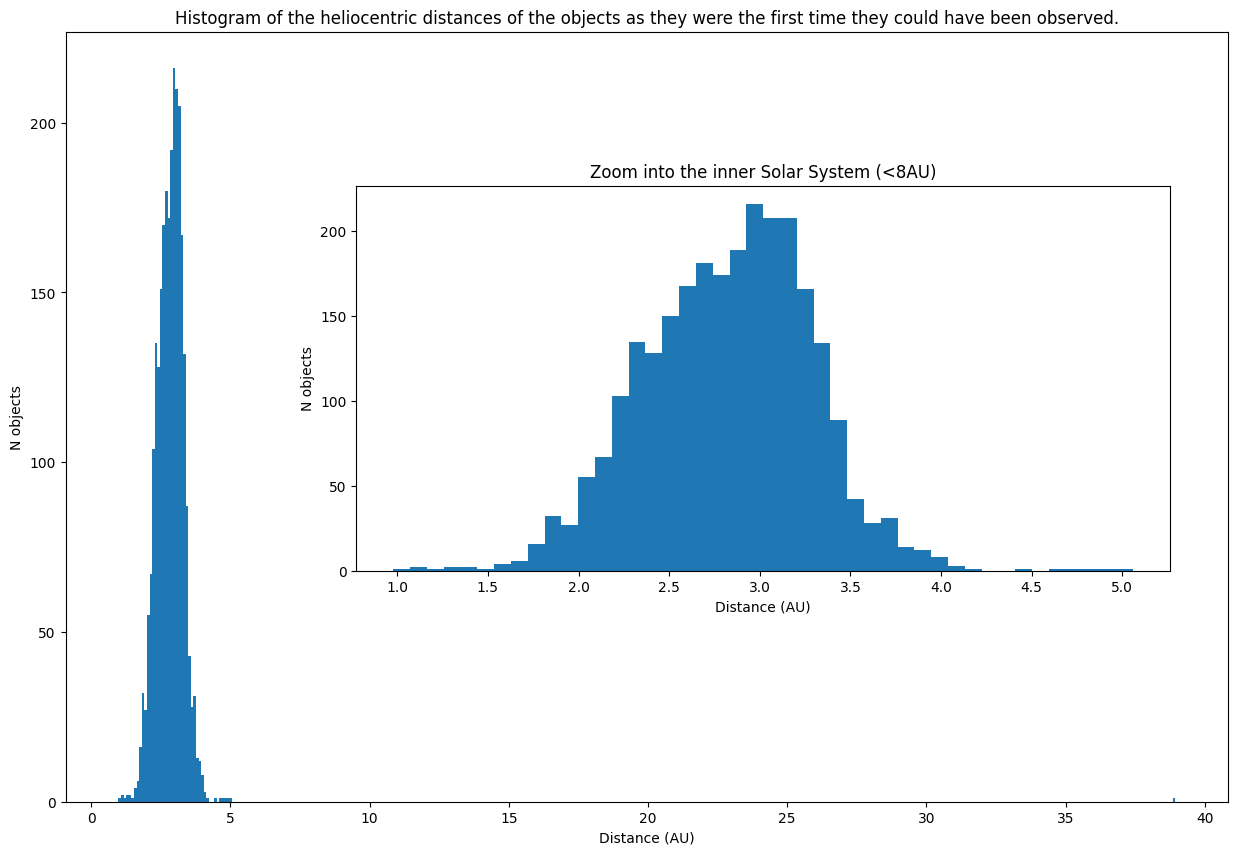

In [13]:
print(f"There are {len(unique_names)} unique known objects crossing the fov, sorted into {len(types)} categories:")
for t in types:
    print(f"    {t}")

kbos = objects[objects['Type'] == 'KBO>Classical>Main']
kbo_names = set(kbos['Name'])
print(f"There is/are {len(kbo_names)} objects marked as KBO>Classical>Main, named:")
for n in kbo_names:
    print(f"    {n}")
    
# See https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges
fig, ax = plt.subplots(figsize=(15, 10))

ax.hist(hdist, bins="auto")
inset_ax = ax.inset_axes([0.25, 0.3, 0.7, 0.5])
inset_ax.hist(hdist[hdist<8], bins="auto")

inset_ax.set_title("Zoom into the inner Solar System (<8AU)")
inset_ax.set_ylabel("N objects")
inset_ax.set_xlabel("Distance (AU)")

ax.set_title("Histogram of the heliocentric distances of the objects as they were the first time they could have been observed.")
ax.set_ylabel("N objects")
_ = ax.set_xlabel("Distance (AU)")

A total of 36142 known objects could have been observed in `i` filter.


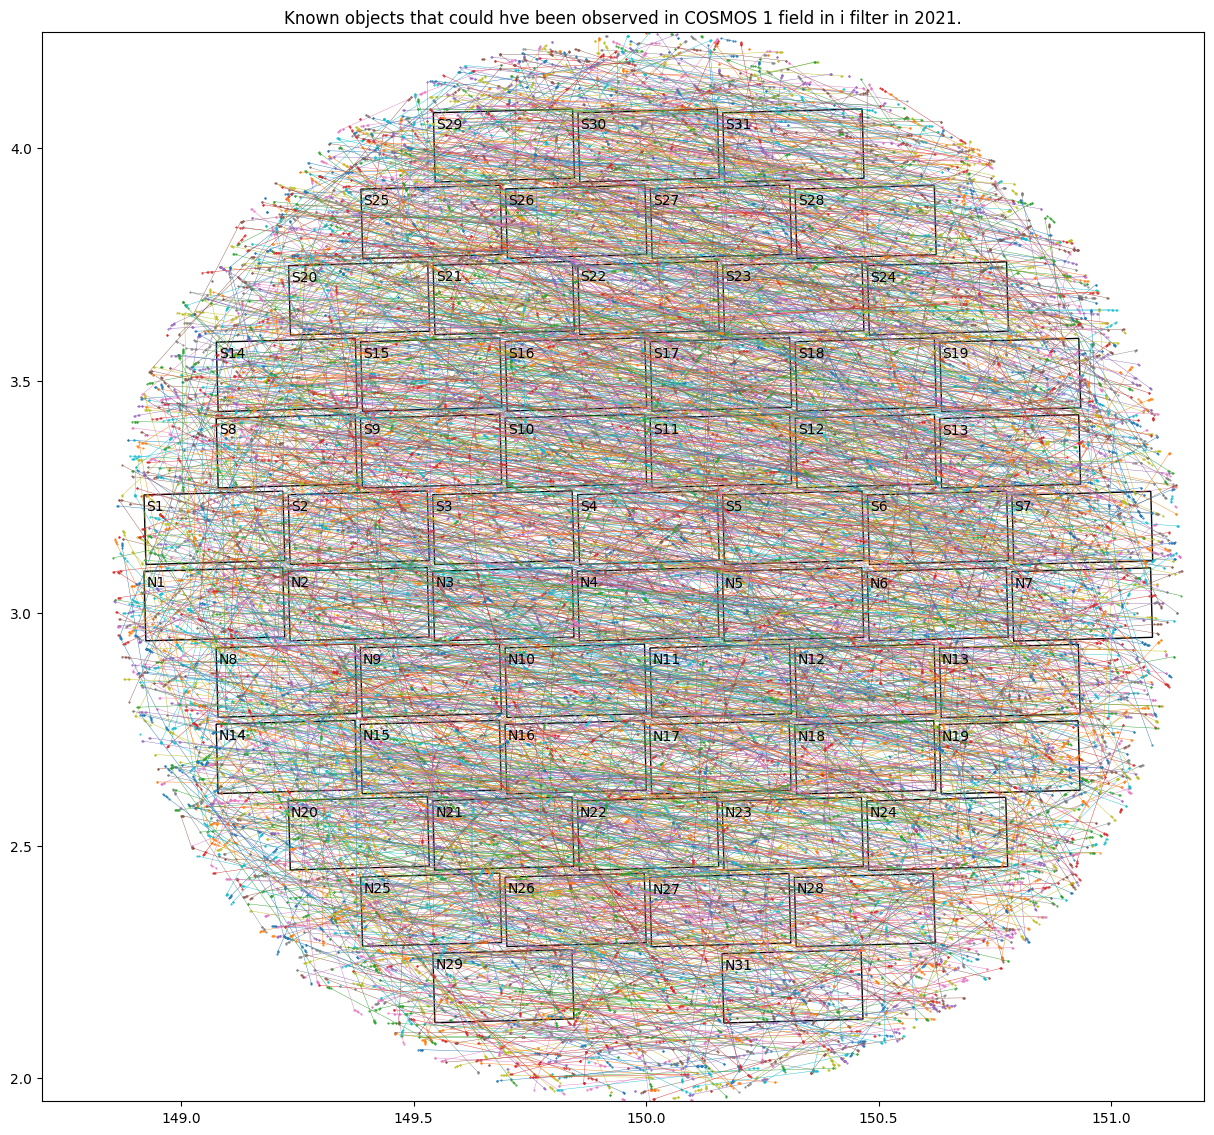

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))

i_filter_only = objects[objects["filter"] == "i DECam SDSS c0003 7835.0 1470.0"]
print(f"A total of {len(i_filter_only)} known objects could have been observed in `i` filter.")
plot_focal_plane(ax, img)
plot_all_objs(ax, i_filter_only, (ra_center, dec_center), show_field=False, lw=0.3, ms=0.5)

ax.set_title("Known objects that could hve been observed in COSMOS 1 field in i filter in 2021.")
ax.set_xlim(148.7, 151.2)
ax.set_ylim(1.95, 4.25)
ax.set_aspect("equal")

The 2008 AQ118 KBO could have been observed a total of 66 times in any filter.


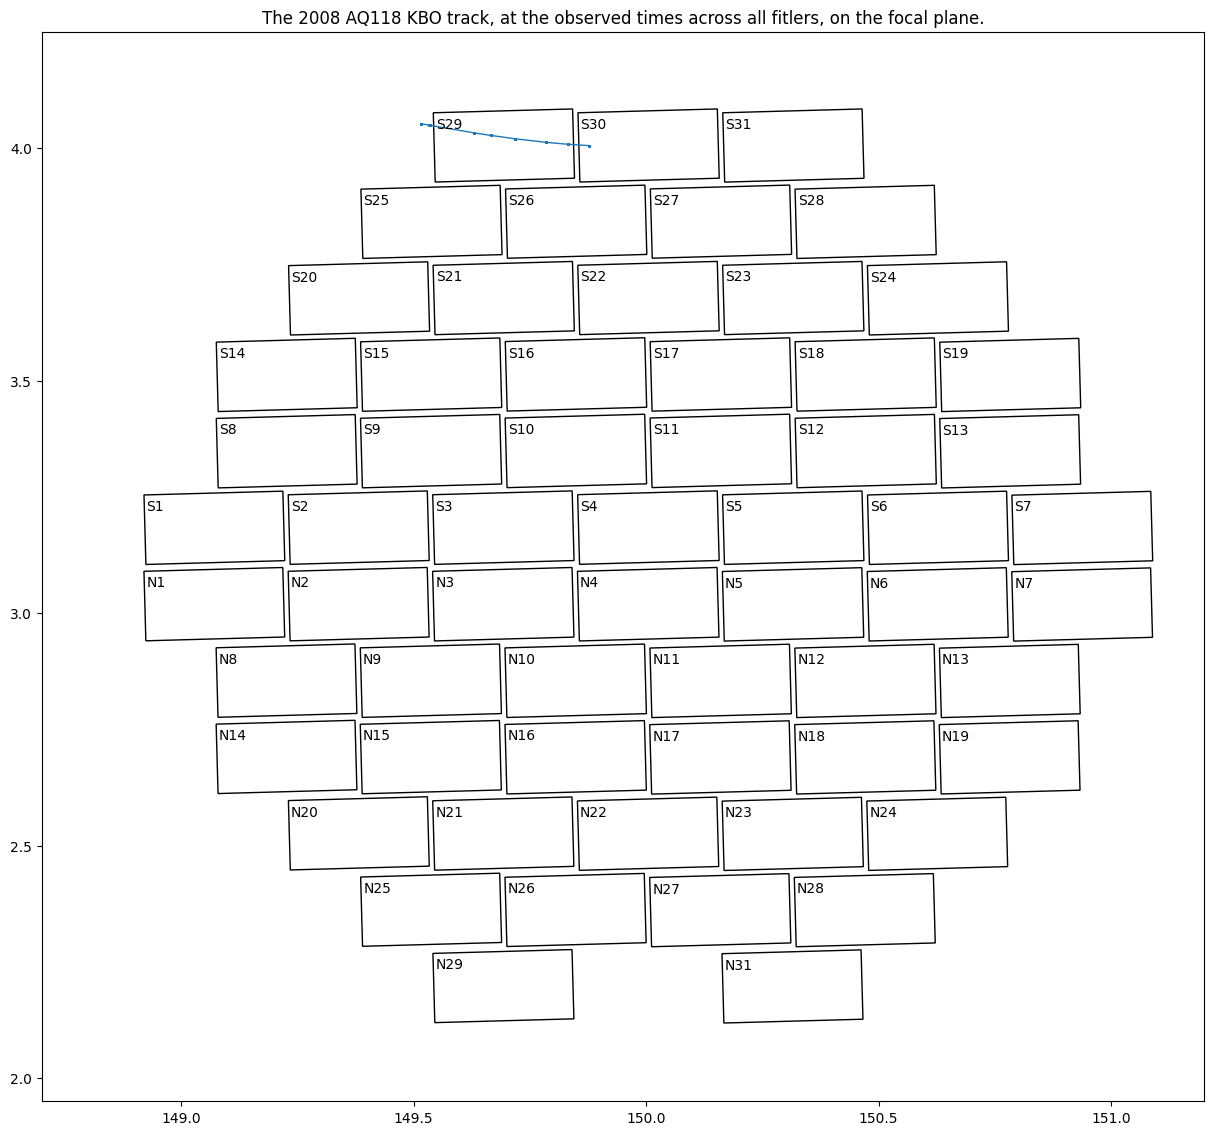

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))

kbo_only = objects[objects["Name"] == "2008 AQ118"]

print(f"The 2008 AQ118 KBO could have been observed a total of {len(kbo_only)} times in any filter.")
plot_focal_plane(ax, img)
plot_all_objs(ax, kbo_only, (ra_center, dec_center), show_field=False, lw=1, ms=1.1)

ax.set_title("The 2008 AQ118 KBO track, at the observed times across all fitlers, on the focal plane.")
ax.set_xlim(148.7, 151.2)
ax.set_ylim(1.95, 4.25)
ax.set_aspect("equal")

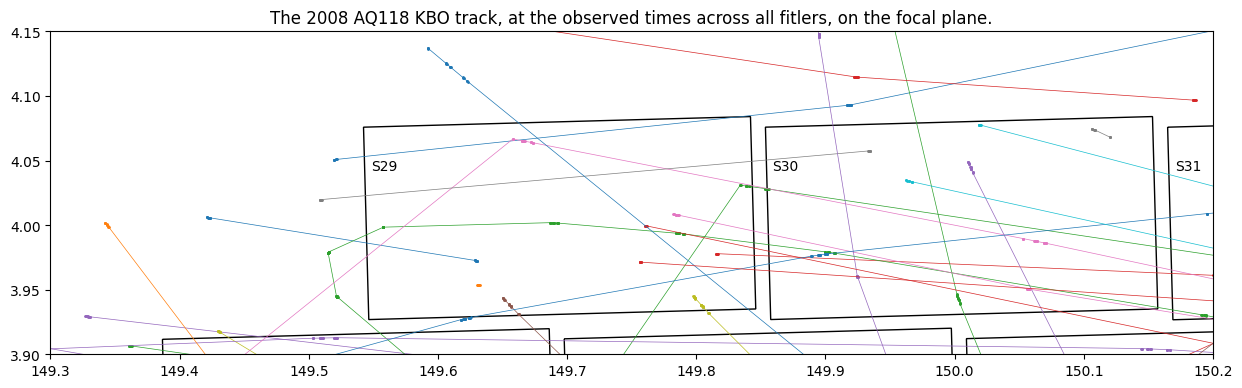

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))

plot_focal_plane(ax, img)
plot_all_objs(ax, objects, (ra_center, dec_center), count=200, lw=0.5, ms=1, show_field=False)

ax.set_title("The 2008 AQ118 KBO track, at the observed times across all fitlers, on the focal plane.")
ax.set_xlim(149.3, 150.2)
ax.set_ylim(3.9, 4.15)
ax.set_aspect("equal")